## ロジスティック回帰による二項分類器の作成

ここでは、TensorFlowを用いて、ロジスティック回帰による二項分類器を実装していきます。

理論的な背景については、下記のBlog記事を参照してください。

・[TensorFlow Tutorialの数学的背景 − MNIST For ML Beginners（その1）](http://enakai00.hatenablog.com/entry/2016/02/14/153904)

### モジュールのインポート

はじめに、必要なモジュールをインポートします。

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, multivariate_normal

### データセットの用意

続いて、トレーニングセットとテストセットのデータを用意するクラス Dataset を作成します。

In [2]:
class Dataset():
    def __init__(self, data1=(60, [13,10], 40), data2=(40, [0,-3],40)):
        n1, mu1, var1 = data1
        n2, mu2, var2 = data2
        data1 = multivariate_normal(mu1,np.eye(2)*var1,n1)
        data2 = multivariate_normal(mu2,np.eye(2)*var2,n2)
        data = np.r_[np.c_[data1,np.ones(n1)], np.c_[data2,np.zeros(n2)]]
        np.random.shuffle(data)

        num_test = int((n1+n2)*0.2)
        self.test_data, self.test_label = np.hsplit(data[0:num_test],[2])
        self.train_data, self.train_label = np.hsplit(data[num_test:],[2])
        self.index = 0
    
    def next_batch(self, n):
        data, label = np.empty(shape=(0, 2)), np.empty(shape=(0, 1))
        while (n>0):
            if n > len(self.train_data) - self.index:
                take = len(self.train_data) - self.index
            else:
                take = n
            data = np.vstack((data, self.train_data[self.index:self.index+take]))
            label = np.vstack((label, self.train_label[self.index:self.index+take]))
            self.index += take
            if self.index >= len(self.train_data):
                self.index = 0
            n -= take
        return np.array(data), np.array(label)

このクラスは、平面上に○と✕のニ種類のデータを乱数で生成します。データは2次元の正規分布に従います。それぞれのデータの「個数、中心座標、分散」をタプルで指定して、インスタンスを生成してください。

In [3]:
dataset = Dataset(data1=(5, [13,10], 40), data2=(5, [0,-3], 40))

この時、生成したデータの20%をテストセットして取り分けておき、残りをトレーニングセットとして使用するようになっています。生成したデータの内容を確認すると次のようになります。ラベル $t$ については、$t=1$ が「○」、$t=0$ が「✕」を表します。

In [4]:
print ("Training data \n", dataset.train_data)    # トレーニング用データ（座標）
print ("Traininng label \n", dataset.train_label) # トレーニング用データ（ラベル）
print ("Test data \n", dataset.test_data)         # テスト用データ（座標）
print ("Test label \n", dataset.test_label)       # テスト用データ（ラベル）

Training data 
 [[ 10.72231727  16.06194879]
 [ 12.54647226  12.83586698]
 [-10.69630037  -6.49066854]
 [  2.13708434  12.47455566]
 [ -6.15146539 -11.7745148 ]
 [ 26.3727768   11.52405229]
 [ -2.44540839  -5.89698468]
 [ -5.57414147  -0.46480183]]
Traininng label 
 [[ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]]
Test data 
 [[  8.22832884  -1.5765989 ]
 [  4.8085763   35.21533587]]
Test label 
 [[ 0.]
 [ 1.]]


実際にトレーニング（パラメーターの最適化）を行う際は、テストデータの一部を順番に取り出して最適化を行うという処理を繰り返します。これを「バッチトレーニング」と言います。next_batchメソッドで指定数のトレーニング用データを順番に取り出すことができます。次の例を見ると、末尾に達すると、再び、頭からデータを取り出していることがわかります。

In [5]:
for i in range(2):
    data, label = dataset.next_batch(5)
    print (data)
    print (label)

[[ 10.72231727  16.06194879]
 [ 12.54647226  12.83586698]
 [-10.69630037  -6.49066854]
 [  2.13708434  12.47455566]
 [ -6.15146539 -11.7745148 ]]
[[ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]]
[[ 26.3727768   11.52405229]
 [ -2.44540839  -5.89698468]
 [ -5.57414147  -0.46480183]
 [ 10.72231727  16.06194879]
 [ 12.54647226  12.83586698]]
[[ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]]


最後に、データを可視化する関数を用意しておきます。

In [6]:
def plot_data(subplot, data, label, color):
    data0_x, data0_y, data1_x, data1_y = [], [], [], []
    for i in range(len(data)):
        if label[i][0] == 0:
            data0_x.append(data[i][0])
            data0_y.append(data[i][1])
        else:
            data1_x.append(data[i][0])
            data1_y.append(data[i][1])
    subplot.scatter(data0_x, data0_y, marker='x', color=color)
    subplot.scatter(data1_x, data1_y, marker='o', color=color)

改めて、100個のデータを生成して、可視化すると次のようになります。青色がトレーニングセットで、赤色がテストセットになります。

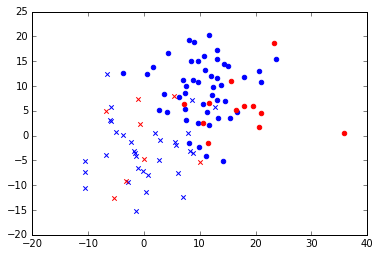

In [7]:
dataset=Dataset(data1=(60, [13,10], 40), data2=(40, [0,-3],40))

fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
plot_data(subplot, dataset.train_data, dataset.train_label, 'blue')
plot_data(subplot, dataset.test_data, dataset.test_label, 'red')

### モデルの定義

次は、トレーニング用データの座標 ${\mathbf x}=(x_0, x_1)$ から、その点が「○」である確率 $y$ を計算する部分のコードです。次の関数を定義しています。

　$y = \sigma({\mathbf x}{\mathbf W}+b \times c_0)$

ここでは、$
{\mathbf W}=\begin{pmatrix}
w_0 \\
w_1
\end{pmatrix}
$ と $b$ がトレーニングで最適化するべきパラメーターになります。

なお、$c_0$ はトレーニング用データの座標の平均値で、これにより、バイアス項（定数項）のオーダーを座標値と合わせています。これは、最適化の処理を高速化するためのテクニックです。

In [8]:
# Create the model
x = tf.placeholder(tf.float32, [None, 2])
w = tf.Variable(tf.zeros([2, 1]))
b = tf.Variable(tf.zeros([1]))
mult = dataset.train_data.flatten().mean() # データの平均値のオーダーにバイアス項を調整
y = tf.sigmoid(tf.matmul(x, w) + b*mult)

TensorFlowでは、トレーニング用のデータを入れる箱をplaceholderクラスで用意して、最適化するべきパラメーターをVariableクラスで用意します。上記のコードでは、x は、1回のバッチに含まれる2次元ベクトル $(x_0, x_1)$ をまとめて保存するために、これらを縦に並べた「None✕2サイズ」の行列として定義しています。（Noneは、要素数が決まっていないという意味です。）

また、パラメーター w と b は、それぞれ、2×1サイズ, 1✕1サイズの行列（多次元配列）として定義している点に注意してください。TensorFlowで扱うパラメーターは、すべて多次元配列として定義する必要があります。

続いて、最適化の指標となるロス関数（対数尤度関数の符号違い）を次式で定義します。

　${\rm Loss} = - \log P = -\sum_n \left\{t_n\log y_n + (1-t_n)\log (1-y_n)\right\}$
 
$y_n$ は、$n$ 番目のデータについて計算された「○」である確率で、$t_n$ は正解のラベルです。

下記のコードでは、y_ が正解ラベルを表します。1回のバッチに含まれるデータをまとめて保存するために、「None✕1サイズ」の行列となります。

In [9]:
# Define loss
y_ = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(y_*tf.log(y) + (1-y_)*tf.log(1-y))

そして、パラメーターを最適化するアルゴリズムとして、勾配降下法を指定します。これには、TensorFlowが事前に用意している関数GradientDescentOptimizerを用います。先ほどのロス関数lossを最小化するという方針を指定します。

In [10]:
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

引数 0.001 は、パラメーターの調整をどの程度の大きさで実施するかを指定するもので、小さすぎると最適化に時間がかかり、大きすぎると新の最適値のまわりでの微調整ができなくなるというトレードオフがあります。この値は、何度かトレーニングを繰り返してチューニングする必要があります。

最後に補助関数として、テストセットに対する正解率を計算する関数を定義しておきます。確率 y が 0.5 より大きいか小さいかで、○か✕かを判定するものとして、これを実際のラベル値と比較しています。

In [11]:
correct_prediction = tf.equal(tf.sign(y-0.5), tf.sign(y_-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### トレーニングの実施

それでは、実際にトレーニングを実施して、パラメーターの最適化を行います。

はじめに、トレーニングを実行する「トレーニングセッション」のインスタンスを生成して、パラメーター（Variableインスタンス）を初期化しておきます。

In [12]:
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

そして、実際にトレーニングを実施するコードが下記になります。ここでは、トレーニングセットから10個のデータを取り出して、バッチでトレーニングを行う処理を100回繰り返しています。

In [13]:
for i in range(100):
    batch_xs, batch_ys = dataset.next_batch(10)
    feed = {x: batch_xs, y_: batch_ys}
    sess.run(train_step, feed_dict=feed)
    if i % 10 == 0:
        feed = {x: dataset.test_data, y_: dataset.test_label}
        lp, acc = sess.run([loss, accuracy], feed_dict=feed)
        print('Loss and Accuracy at step %s: %s, %s' % (i, lp, acc))

Loss and Accuracy at step 0: 10.6814, 0.8
Loss and Accuracy at step 10: 6.84003, 0.8
Loss and Accuracy at step 20: 6.33738, 0.85
Loss and Accuracy at step 30: 5.96427, 0.9
Loss and Accuracy at step 40: 5.73125, 0.9
Loss and Accuracy at step 50: 5.42211, 0.9
Loss and Accuracy at step 60: 5.25814, 0.9
Loss and Accuracy at step 70: 5.08392, 0.9
Loss and Accuracy at step 80: 4.98132, 0.9
Loss and Accuracy at step 90: 4.82485, 0.9


placeholderに代入する値を変数feed_dictに指定して、トレーニングセッションのrunメソッドを実行すると、パラメーター（Variableインスタンス）が自動的に修正されます。また、10回のバッチごとに、その時点でのロス関数の値とテストセットに対する正解率を表示しています。

実行結果を見ると、バッチを繰り返すことで、ロス関数の値が小さくなっていくことがわかります。

最後に、実行結果をグラフに可視化しておきます。下記は、最適化されたパラメーターによる境界線を表示する関数です。

Variableインスタンスは、evalメソッドで値を取り出すことができますが、多次元配列として値が得られるので、そこから成分指定で実際の値を取り出す必要があります。

In [14]:
def plot_result(w,b, mult):
    weight, bias = w.eval(), b.eval()
    xs, ys = np.hsplit(dataset.train_data,[1])
    wx, wy, b = weight[0][0], weight[1][0], bias[0]
    linex = np.arange(xs.min()-5, xs.max()+5)
    liney = - linex * wx/wy - b*mult/wy
    subplot.plot(linex, liney, color='red')

先に定義したデータの可視化関数とあわせて、全体を表示すると次のようになります。

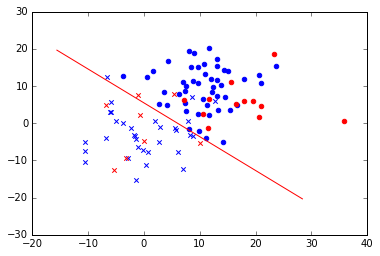

In [15]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
plot_data(subplot, dataset.train_data, dataset.train_label, 'blue')
plot_data(subplot, dataset.test_data, dataset.test_label, 'red')
plot_result(w, b, mult)